In [118]:
%matplotlib inline
import numpy as np
import numpy.linalg as la
import pandas as pd
from sklearn.cross_validation import KFold
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import itertools
from pprint import pprint
import random as rnd
from math import sqrt
from sklearn.metrics import f1_score

In [4]:
def plot(predictor, X, y, grid_size, filename):
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, grid_size),
                         np.linspace(y_min, y_max, grid_size),
                         indexing='ij')
    flatten = lambda m: np.array(m).reshape(-1,)

    result = []
    for (i, j) in itertools.product(range(grid_size), range(grid_size)):
        point = np.array([xx[i, j], yy[i, j]]).reshape(1, 2)
        result.append(predictor.predict(point))

    Z = np.array(result).reshape(xx.shape)

    plt.contourf(xx, yy, Z,
                 cmap=cm.Paired,
                 levels=[-0.001, 0.001],
                 extend='both',
                 alpha=0.8)
    plt.scatter(flatten(X[:, 0]), flatten(X[:, 1]),
                c=flatten(y), cmap=cm.Paired)
    plt.xlim(x_min, x_max)
    plt.ylim(y_min, y_max)
    plt.savefig(filename)

In [100]:
def to_zero_pos(arr):
    return [0 if i < 0 else 1 for i in arr]

def to_neg_pos(arr):
    return [-1 if i == 0 else 1 for i in arr]

In [6]:
class SVM():
    """
        http://cs229.stanford.edu/materials/smo.pdf
    """
    def __init__(self, max_iter=10000, kernel_type='linear', C=1.0, epsilon=0.001):
        self.kernels = {
            'linear' : self.kernel_linear,
            'quadratic' : self.kernel_quadratic,
            'gaussian' : self.kernel_gaussian
        }
        self.max_iter = max_iter
        self.kernel_type = kernel_type
        self.C = C
        self.epsilon = epsilon
        
    def fit(self, X, y):
        # Initialization
        n, d = X.shape[0], X.shape[1]
        alpha = np.zeros((n))
        kernel = self.kernels[self.kernel_type]
        count = 0
        while True:
            count += 1
            alpha_prev = np.copy(alpha)
            for j in range(0, n):
                i = self.get_rnd_int(0, n-1, j) # Get random int i~=j
                x_i, x_j, y_i, y_j = X[i,:], X[j,:], y[i], y[j]
                k_ij = kernel(x_i, x_i) + kernel(x_j, x_j) - 2 * kernel(x_i, x_j)
                if k_ij == 0:
                    continue
                alpha_prime_j, alpha_prime_i = alpha[j], alpha[i]
                (L, H) = self.compute_L_H(self.C, alpha_prime_j, alpha_prime_i, y_j, y_i)

                # Compute model parameters
                self.w = self.calc_w(alpha, y, X)
                self.b = self.calc_b(X, y, self.w)

                # Compute E_i, E_j
                E_i = self.E(x_i, y_i, self.w, self.b)
                E_j = self.E(x_j, y_j, self.w, self.b)

                # Set new alpha values
                alpha[j] = alpha_prime_j + float(y_j * (E_i - E_j))/k_ij
                alpha[j] = max(alpha[j], L)
                alpha[j] = min(alpha[j], H)

                alpha[i] = alpha_prime_i + y_i*y_j * (alpha_prime_j - alpha[j])

            # Check convergence
            diff = np.linalg.norm(alpha - alpha_prev)
            if diff < self.epsilon:
                break

            if count >= self.max_iter:
                print("Iteration number exceeded the max of %d iterations" % (self.max_iter))
                return
        # Compute final model parameters
        self.b = self.calc_b(X, y, self.w)
        if self.kernel_type == 'linear':
            self.w = self.calc_w(alpha, y, X)
        # Get support vectors
        alpha_idx = np.where(alpha > 0)[0]
        #pprint("support vectors:")
        #pprint(alpha_idx)
        support_vectors = X[alpha_idx, :]
        return support_vectors, count
    
    def predict(self, X):
        return self.h(X, self.w, self.b)
    def calc_b(self, X, y, w):
        b_tmp = y - np.dot(w.T, X.T)
        return np.mean(b_tmp)
    def calc_w(self, alpha, y, X):
        return np.dot(alpha * y, X)
    # Prediction
    def h(self, X, w, b):
        return np.sign(np.dot(w.T, X.T) + b).item() #.astype(int)
    # Prediction error
    def E(self, x_k, y_k, w, b):
        return self.h(x_k, w, b) - y_k
    def compute_L_H(self, C, alpha_prime_j, alpha_prime_i, y_j, y_i):
        if(y_i != y_j):
            return (max(0, alpha_prime_j - alpha_prime_i), min(C, C - alpha_prime_i + alpha_prime_j))
        else:
            return (max(0, alpha_prime_i + alpha_prime_j - C), min(C, alpha_prime_i + alpha_prime_j))
    def get_rnd_int(self, a,b,z):
        i = z
        while i == z:
            i = rnd.randint(a,b)
        return i
    # Define kernels
    def kernel_linear(self, x1, x2):
        return np.dot(x1, x2.T)
    def kernel_quadratic(self, x1, x2):
        return (np.dot(x1, x2.T) ** 2)  
    def kernel_gaussian(self, x, y):
        sigma = 0.06
        exponent = -np.sqrt(la.norm(x-y) ** 2 / (2 * sigma ** 2))
        return np.exp(exponent)
        

In [113]:
class KNNClassifier():
    def __init__(self, k, distance):
        self.k = k;
        self.distance = distance
        
    def train(self, X, y):
        self.train_X = X
        self.train_y = y
        self.k = min(self.k, len(X))
        
    def predict(self, x):
        dist = []
        for i in range(len(self.train_X)):
            dist.append((self.distance(x, self.train_X[i]), self.train_y[i]))
        dist.sort()
        dist = dist[:self.k]
        #pprint(dist)
        r = {}
        for d in dist:
            r[d[1]] = r.get(d[1], 0) + 1
        return sorted(r, key = r.get, reverse=True)[0]
    
def euclidean(a, b):
    rv = 0
    for i in range(len(a)):
        rv += (a[i] - b[i]) ** 2
    return sqrt(rv)

In [116]:
def score_SVM(train, test):
    X = train[:,[0,1]]
    y = train[:,2]
    svn = SVM()
    sv, ite = svn.fit(X, y) # pprint(y.shape) #(40,)
    pprint("iter = {}".format(ite))
    predicted = []
    y = []
    for i in test:
        res = svn.predict(i[[0,1]])
        y.append(i[2])
        predicted.append(res)
    predicted = to_zero_pos(predicted)
    y = to_zero_pos(y)
    return f1_score(y, predicted)

def score_KNN(train, test):
    X = train[:, [0,1]]
    y = train[:, 2].astype(int)
    knn = KNNClassifier(5, euclidean)
    knn.train(X, y)
    predicted = [knn.predict(x) for *x, y in test]
    predicted = to_zero_pos(predicted)
    y = to_zero_pos(test[:,2])
    return f1_score(y, predicted)

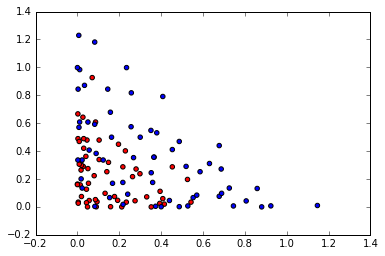

In [103]:
df = pd.read_csv("chips.txt", header=None, names=["x", "y", "type"])
df['color'] = df['type'].map(lambda x: 'red' if x else 'blue')
xx, yy = zip(*[(i[0]**2, i[1]**2) for i in zip(list(df['x']), list(df['y']))])
plt.scatter(xx, yy, c=df['color'])

In [104]:
x_y_type = np.array(list(zip(xx, yy, to_neg_pos(df['type']))))

In [119]:
kf = KFold(len(x_y_type), n_folds=5, shuffle=True)
f1_SVM = []
f1_KNN = []
for train_index, test_index in kf:   
    res = score_SVM(x_y_type[train_index], x_y_type[test_index])
    f1_SVM.append(res)
    res = score_KNN(x_y_type[train_index], x_y_type[test_index])
    f1_KNN.append(res)

pprint("SVM:")
pprint(f1_SVM)
pprint("SVM mean = {}".format(np.mean(f1_SVM)))
pprint("KNN:")
pprint(f1_KNN)
pprint("KNN mean = {}".format(np.mean(f1_KNN)))

'iter = 4'
'iter = 5'
'iter = 5'
'iter = 3'
'iter = 7'
'SVM:'
[0.72000000000000008,
 0.77777777777777779,
 0.69230769230769229,
 0.64000000000000001,
 0.64000000000000001]
'SVM mean = 0.694017094017094'
'KNN:'
[0.69230769230769229,
 0.5,
 0.71428571428571419,
 0.81481481481481477,
 0.71999999999999986]
'KNN mean = 0.6882816442816442'
